In [1]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [2]:
import json

In [68]:
points_recep = sc.read.json('datos/points-recep.jsonlines').rdd

### Cantidad de recepciones por antena

In [83]:
for i in range(4):
    cant = points_recep.map(lambda x: len(x['recep_{}'.format(i)])).sum()
    print('cant recepciones antena {}: {}'.format(i, cant))


cant recepciones antena 0: 4043
cant recepciones antena 1: 2173
cant recepciones antena 2: 1010
cant recepciones antena 3: 1639


### Stdev de las recepciones de una misma emision

In [75]:
import numpy as np
for i in range(4):
    recep_field = 'recep_{}'.format(i)
    recepciones = points_recep.filter(lambda x: len(x[recep_field]) > 0).map(lambda x: x[recep_field])
    print(recepciones.map(lambda x: np.std(x)).mean())

4.150602119258519
5.176247019458748
15.530845631225787
21.71106617735749


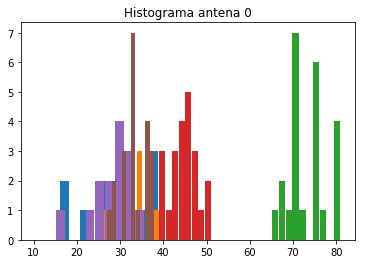

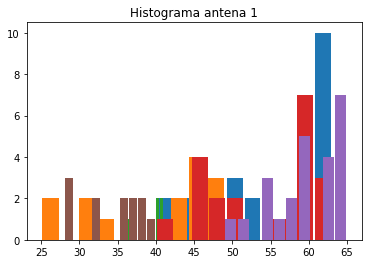

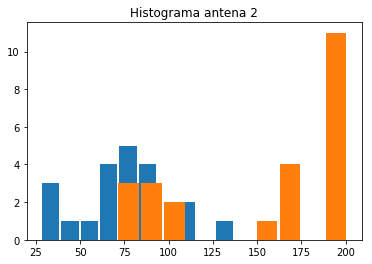

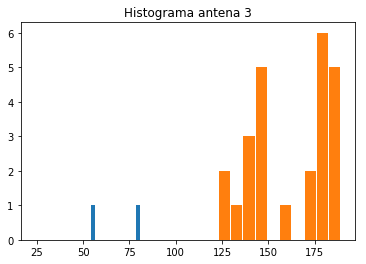

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

for i in range(4):
    recep_field = 'recep_{}'.format(i)
    recepciones = points_recep.filter(lambda x: len(x[recep_field]) > 0).map(lambda x: x[recep_field])
    l = recepciones.sample(False, fraction=0.05).collect()

    plt.figure()
    plt.title('Histograma antena {}'.format(i))
    for i in range(len(l)):
        plt.hist(l[i], rwidth=0.9)
    



### Variación de la potencia de las señales en funcion de la cantidad de señales recibidas

/Users/alew/py3/lib/python3.6/site-packages/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


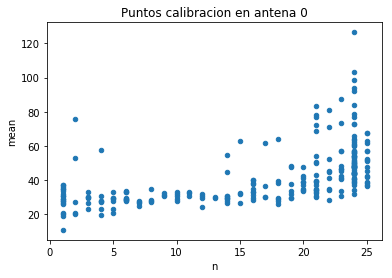

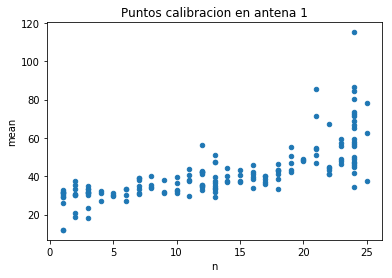

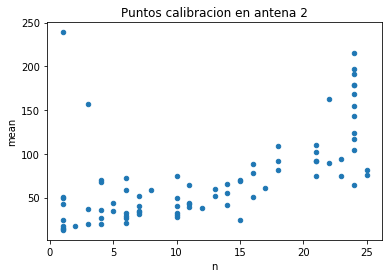

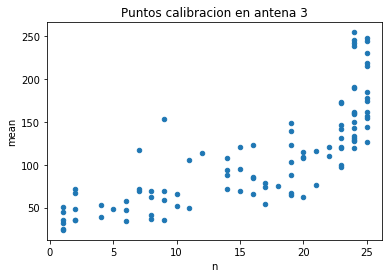

In [80]:
for i in range(4):
    recep_field = 'recep_{}'.format(i)
    p = points_recep.map(lambda x: {'n': len(x[recep_field]),'mean': float(np.mean(x[recep_field]))}).filter(lambda x: x['n'] > 0).toDF().toPandas()
    p.plot.scatter(x='n', y='mean')
    plt.title('Puntos calibracion en antena {}'.format(i))




### Mapa con colores

In [26]:
posicion_antenas = [(464063.427327232,6110287.773965900), (464063.427327232,6110287.773965900), (464063.427327232,6110287.773965900), (464063.427327232,6110287.773965900)]
coordenadas_UTM = sc.read.csv('datos/DistancesCoordenadasUTM.csv', header=True, inferSchema=True).rdd
dict_coordenadas = coordenadas_UTM.map(lambda x: (x['Punto'],(x['X'], x['Y']))).collectAsMap()
global dict_coordenadas

In [70]:
def calculate_avg_power(grouped_row, antena):
    signals = list(map(lambda x: x['recep_{}'.format(antena)], list(grouped_row[1])))
    suma_power = 0
    n = 0
    for l in signals:
        for s in l:
            suma_power += s
            n += 1
    mean = suma_power/float(n) if n > 0 else 0
    return {
        'Punto': grouped_row[0],
        'mean': mean
    }


In [71]:
def add_coord(row):
    coordinadas = dict_coordenadas[row['Punto']]
    row['x'] = coordinadas[0]
    row['y'] = coordinadas[1]
    return row


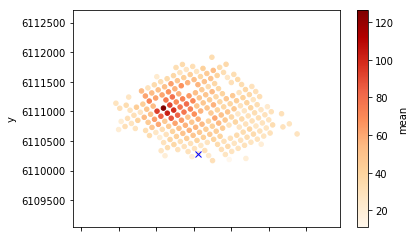

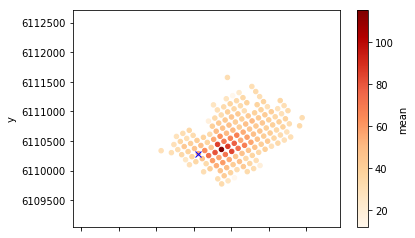

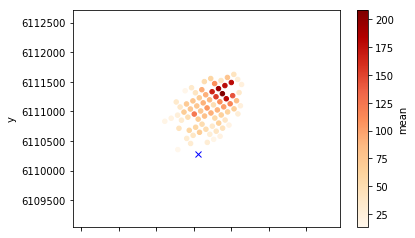

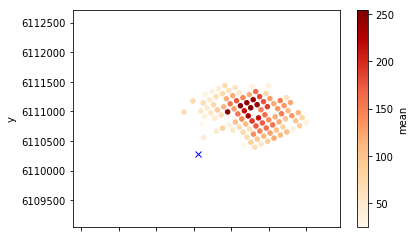

In [63]:
for antena in range(4):
    points_sig = points_recep.groupBy(lambda x:x['Punto']).map(lambda x: calculate_avg_power(x,antena)).filter(lambda x: x['mean'] != 0)
    points_sig_with_coord = points_sig.map(add_coord)
    ax = pd.DataFrame(points_sig_with_coord.collect()).plot.scatter(x='x', y='y',c='mean',cmap='OrRd')

    pos_antena = posicion_antenas[antena]
    ax.plot(pos_antena[0], pos_antena[1], "xb")
    plt.ylim(6109042.35153865,6112715.80637111)
    plt.xlim(462385.503783397, 465958.114906211)


### Distancia promedio de las antenas a los puntos

In [67]:
import math
for antena in range(4):
    pos_antena = posicion_antenas[antena]
    mean_dist = coordenadas_UTM.map(lambda p: math.sqrt((pos_antena[0]-p['X'])**2+(pos_antena[1]-p['Y'])**2)).mean()
    print('mean distance to antenna {}: {}'.format(antena, mean_dist))

mean distance to antenna 0: 1064.0372202604967
mean distance to antenna 1: 1064.0372202604967
mean distance to antenna 2: 1064.0372202604967
mean distance to antenna 3: 1064.0372202604967
